In [4]:
import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")

[*********************100%***********************]  1 of 1 completed


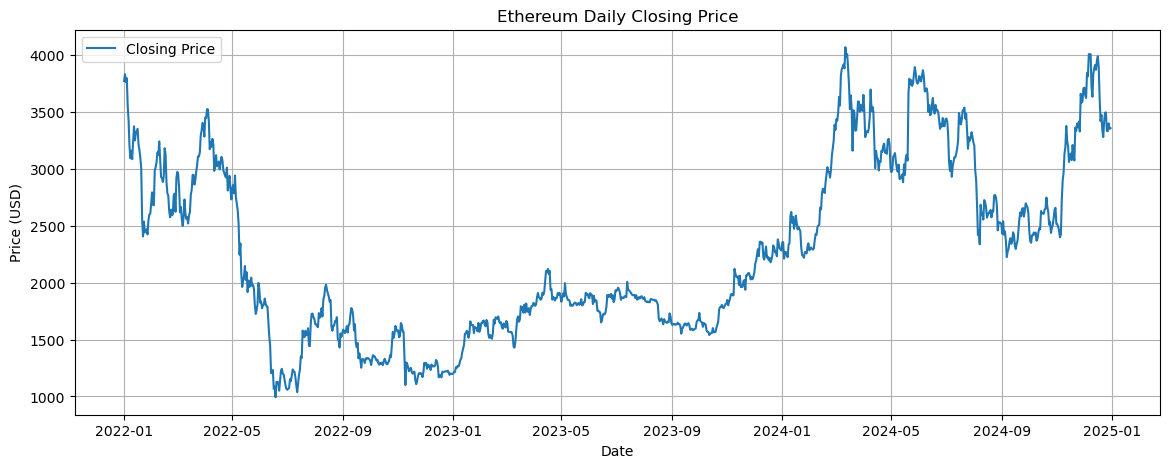

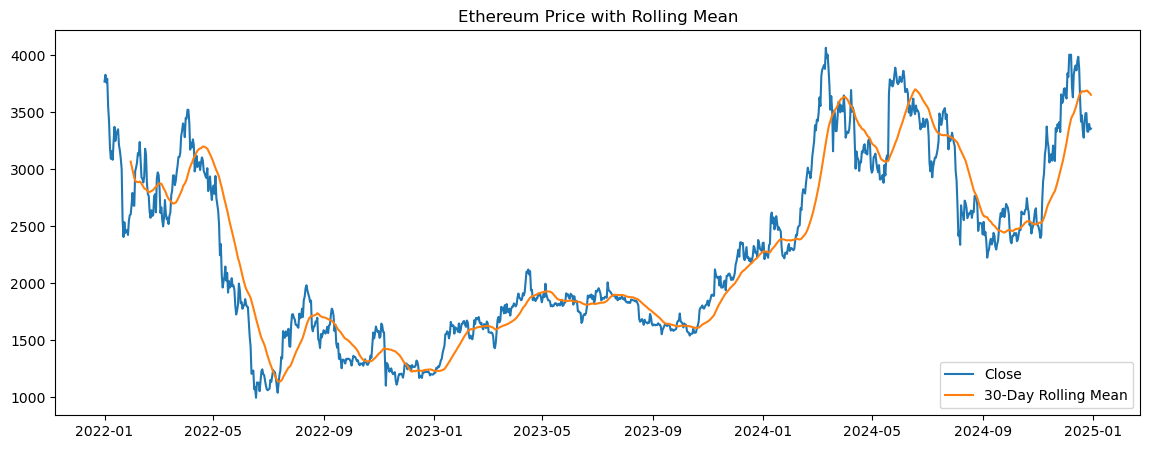


--- ADF Test on Original Series ---
ADF Statistic: -2.210893183196284
p-value: 0.20231564221690607
Data is non-stationary

--- ADF Test on Differenced Series ---
ADF Statistic: -17.392917076162128
p-value: 4.997379889319687e-30
Data is stationary


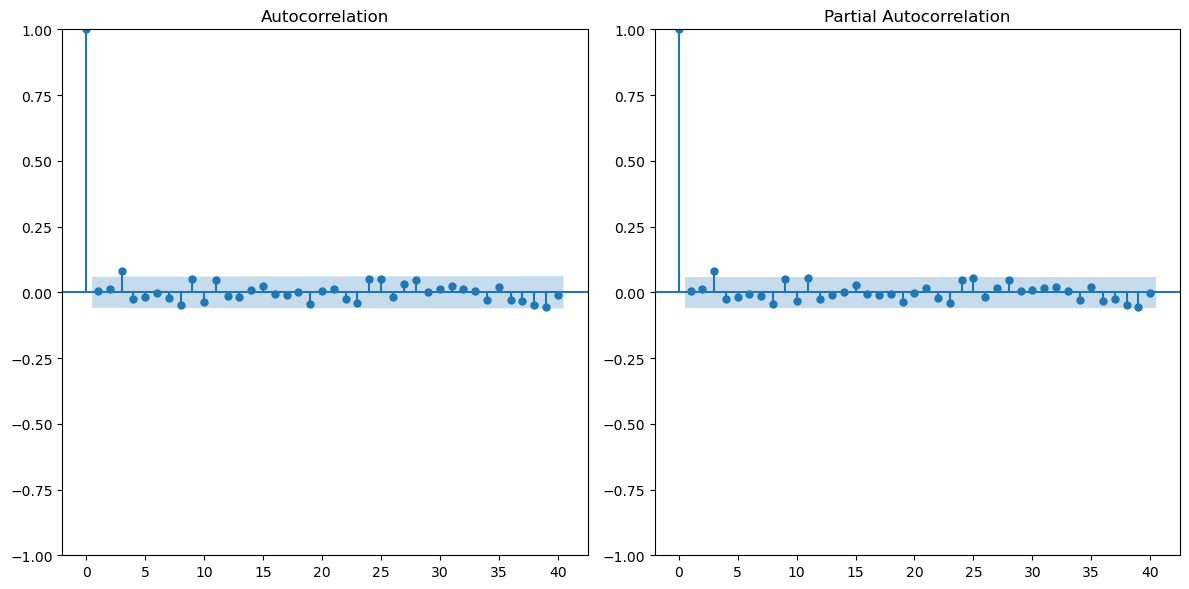

                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1095
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6389.919
Date:                Thu, 17 Apr 2025   AIC                          12785.838
Time:                        21:53:32   BIC                          12800.831
Sample:                    01-01-2022   HQIC                         12791.512
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0017      7.409      0.000      1.000     -14.520      14.524
ma.L1          0.0017      7.412      0.000      1.000     -14.526      14.530
sigma2      6847.2911    153.149     44.710      0.0

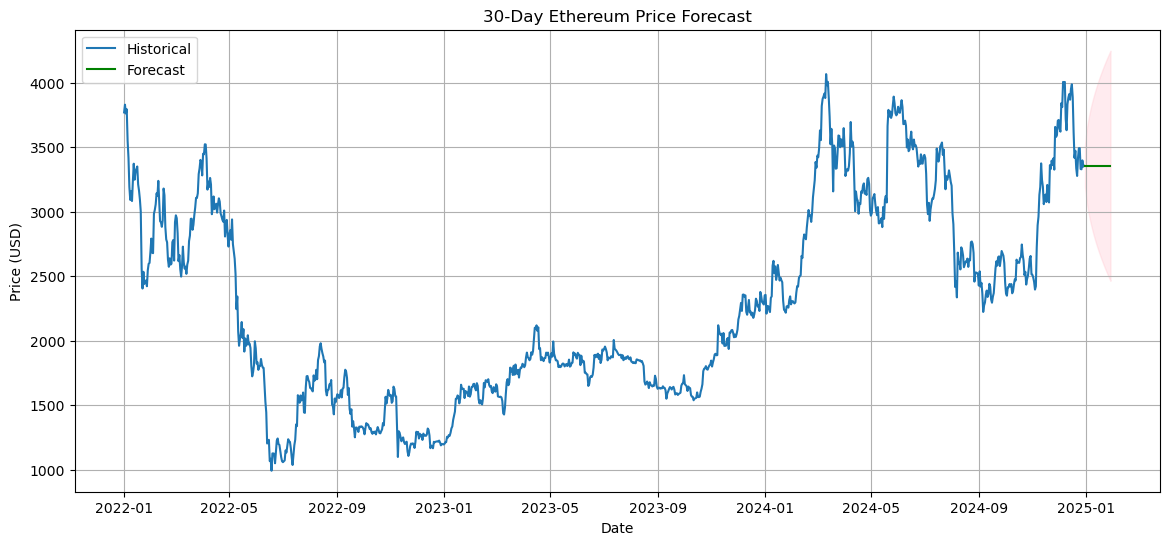

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Step 2: Data Collection
eth = yf.download('ETH-USD', start='2022-01-01', end='2024-12-31')
eth = eth[['Open', 'High', 'Low', 'Close', 'Volume']]
eth.dropna(inplace=True)

# Step 3: Data Preparation
eth.index = pd.to_datetime(eth.index)
eth = eth.asfreq('D')
eth.ffill(inplace=True)

# Step 4: EDA
plt.figure(figsize=(14, 5))
plt.plot(eth['Close'], label='Closing Price')
plt.title('Ethereum Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

eth['Rolling_Mean'] = eth['Close'].rolling(window=30).mean()
eth['Rolling_STD'] = eth['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 5))
plt.plot(eth['Close'], label='Close')
plt.plot(eth['Rolling_Mean'], label='30-Day Rolling Mean')
plt.title('Ethereum Price with Rolling Mean')
plt.legend()
plt.show()

# Step 5: Stationarity Test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary")

print("\n--- ADF Test on Original Series ---")
adf_test(eth['Close'])

# Differencing
eth['Close_Diff'] = eth['Close'].diff()
print("\n--- ADF Test on Differenced Series ---")
adf_test(eth['Close_Diff'].dropna())

# Step 6: ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(eth['Close_Diff'].dropna(), ax=plt.gca(), lags=40)
plt.subplot(1, 2, 2)
plot_pacf(eth['Close_Diff'].dropna(), ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

# Step 7: ARIMA Model
model = ARIMA(eth['Close'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Step 8: Model Evaluation
# Use model.predict(start=1) since d=1 (first difference)
eth['Predicted'] = model_fit.predict(start=1, end=len(eth))

# Align Close and Predicted (drop first row of Close to match)
actual = eth['Close'][1:]
predicted = eth['Predicted'][1:]

rmse = sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted)

print(f"\nModel Evaluation:\nRMSE = {rmse:.2f}\nMAPE = {mape:.2%}")

# Step 9: Forecasting Next 30 Days
forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=eth.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(eth['Close'], label='Historical')
plt.plot(forecast_index, forecast_values, label='Forecast', color='green')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("30-Day Ethereum Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()
